## Imports

In [1]:
from ipynb.fs.full.Jacobian import *

import numpy as np
from numpy import linalg as LA
import sympy as sp

import matplotlib.pyplot as plt
import math

## Global Variables

In [153]:
#Time variables
interval = 10
delta = 0.01

#Numbers represent how far we want to be precised.
Epsilon = 10**-2
Nnewton = 10

## Transitionals functions
### Solver with one equation

In [3]:
"""
    Create the function f wich correspond to this equality : du/dt = expr(u, v). 
    Here du/dt -> un - un-1 / delta
    
    @return: the new function ready to be evaluated.
    
    @var: the symbol we want to evalute (u or v)
    @term_1: the previous term
    @expr: the function tied.
"""

def create_f(var, term_1, expr):
    return (var - term_1)/delta - expr

In [4]:
"""
    Create a list like that : [[t0, u0], [t1, u1], ..., [tn, un]]

    @return: [[t0, u0], [t1, u1], ..., [tn, un]]
    
    @time: [t0, t1, ...]
    @function: [u0, u1, ...]
"""

def result_one_eq(time, function):
    final_points = []
    for i in range(len(function)):
        final_points.append([time[i], function[i]])
        
    return final_points

### Solver with 2 equations

In [14]:
"""
    Same as create_f. The only difference is that this time we 
    keep it in a vector cause we have two different functions.
    
    @return: a vector containing the 2 new functions ready to be evaluated.
    
    @xk_1: previous term
    @f1: first function
    @f2 second function
"""

def create_2_f(xn_1_global, f1, f2):
    return np.array([create_f(u, xn_1_global[0], f1), create_f(v, xn_1_global[1], f2)])

In [53]:
"""
    Create the 2x2 matrix wich correspond to the derivate of F(xk) 
    when xk is vector like xk = (f1, f2).
    This matrix = [df1/du , df2/du]
                  [df1/dv , df2/dv]
    
    @return: new matrix created.
    
    @xk_1: previous term
    @f1: first function
    @f2: second function
"""

def f_prime_2_eqs(xk_1, f1, f2):
    res = np.array([[0., 0.], [0., 0.]])
    symbols = [u, v]
    tab_f = [f1, f2]
    
    for i in range(2):
        for j in range(2):
            res[i][j] = Jacobian_square_mat(symbols[i], tab_f[j]).subs(symbols[i], xk_1[j])
    
    return res

In [55]:
"""
    Create the term F(xk_1) wich is a vector of size 2 containing the evaluation
    respectivly of f1 and f2.
    
    @return: the term F(xk_1)
    
    @xk_1 previous term
    @fu: first expression in the inital system.
    @fv: second expr in the initial system.
    @vec_f: list containing f1 and f2
    @i: index to recup the correct previous term of the function.
"""

def create_fxk_1(xk_1, vec_f):
    res = np.array([0., 0.])
    for i in range(2):
        
        res[i] = vec_f[i].evalf(subs={u: xk_1[0], v: xk_1[1]})
    
    return res

In [8]:
"""
    Create a list containings the lists of points to build the u function
    and the v function.
    
    @return: [ [ [t0, u0], [t1, u1], ..., [tn, un] ] , [ [t0, v0], [t1, v1], ..., [tn, vn] ] ]
    
    @time: list containing t0, t1, t2, ...
    @fu: list containing u0, u1, u2, ...
    @fv: list containing v0, v1, v2, ...
"""

def result_2_eq(time, fu, fv):
    #Creation of our final list containing tuples like that: (time, function)
    final_points_u = []
    final_points_v = []
    
    for i in range(len(fu)):
        final_points_u.append([time[i], fu[i]])
        final_points_v.append([time[i], fv[i]])
        
    return [final_points_u, final_points_v]

## Solver for one differencial equation

In [9]:
def Solver_one_equation(expr, u0):
    t0 = 0
    i = 1
    f_uk = 1
    uk_1 = u0
    nb = 0
    
    #Each list is an axis.
    #Time = [t0, t1, t2, ...., tn]
    #Function = [u0, u1, u2, ...., un]
    function = [u0]
    time = [t0]
    
    first = True
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        nb = 0
        #Newton's method
        while(f_uk > Epsilon or nb < Nnewton):
            
            f_uk_1 = 0
            f_uk_1_prime = 0
            
            # First step, we change our equation to f(x) = 0
            f = create_f(u, uk_1, expr)
            
            # We recup the term f(uk-1)
            if(first):
                f_uk_1 = f.subs(u, uk_1)
                first = False
            
            else:
                f_uk_1 = f.subs(u, function[i-1])
            
            #We recup the term f'(uk_1)
            f_uk_1_prime = Jacobian_one(f).subs(u, uk_1)

            #Formula : uk = uk_1 - (f(uk_1) / f'(uk_1))
            uk = uk_1 - (f_uk_1 / f_uk_1_prime)

            #Check the approximation. If f_uk < Epsilon = good approximation
            f_uk = f.subs(u, uk)
            
            uk_1 = uk
            if(f_uk < Epsilon):
                break
        
        #Update our 2 lists and indexes.
        time.append(t0)
        function.append(uk)
        f_uk = 1
        i += 1
        nb += 1

    return result_one_eq(time, function)

## Solver for 2 differentials equations

In [176]:
def Solver_two_equations(u0, v0, f1, f2):
    t0 = 0
    f_xk = 1
    uk_1 = u0
    vk_1 = v0
    xk_1 = np.array([u0, v0])
    xn_1_global = np.array([u0, v0])
    
    #Each list is an axis.
    #Time = [t0, t1, t2, ...., tn]
    #Functions = [u0, u1, u2, ...., un]
    fu = [u0]
    fv = [v0]
    time = [t0]
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        nb = 0
        
        #Newton's method
        while(nb < Nnewton):
            nb+=1
            
            # First step, we change our equation to F(x) = 0
            vec_f = create_2_f(xn_1_global, f1, f2)
            
            #Creating F(xk-1)
            F_xk_1 = create_fxk_1(xk_1, vec_f)
            
            #Creating F'(xk-1)
            F_xk_1_prime = f_prime_2_eqs(xk_1, vec_f[0], vec_f[1])
        
            
            #Formula : xk = xk_1 - tr(F'(xk_1)) * F(xk_1)
            xk = xk_1 - np.dot(LA.inv(F_xk_1_prime), F_xk_1)
          
            #2 types 
            #f_xk = np.array([0., 0.])
            #f_xk = np.array([vec_f[0].evalf(subs={u: xk[0], v: xk[1]}), vec_f[1].evalf(subs={u: xk[0], v: xk[1]})]) 
            #norm_f_xk = LA.norm(f_xk)
            norm_xk = LA.norm(xk - xn_1_global)
            if(norm_xk < Epsilon):
                break
            
            xk_1 = xk
        
        #Update our 3 lists and indexes.
        time.append(t0)
        fu.append(xk[0])
        fv.append(xk[1])
        
        xn_1_global = np.array([xk[0],xk[1]])
        f_xk = 1        
      
    return result_2_eq(time, fu, fv)

## Unitary tests
### Tests with only one equation.
### exp(-x)

In [11]:
a = np.matrix([[11, 1], [-1, 9]])
LA.inv(a)

matrix([[ 0.09, -0.01],
        [ 0.01,  0.11]])

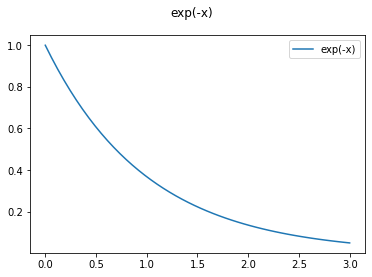

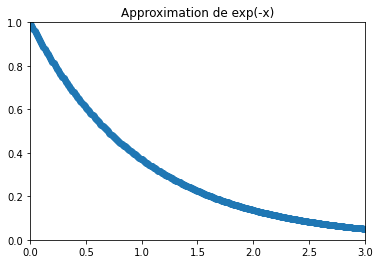

In [164]:
fig, ax = plt.subplots()
x = np.linspace(0, 3, 50)
y = np.exp(-x)
ax.plot(x, y, label ='exp(-x)')
plt.legend()  
plt.suptitle('exp(-x)')
plt.show()

res = Solver_one_equation(-u, 1)


absi = []
for i in range(0, len(res)):
    absi.append(res[i][0])
coords = []
for j in range(0, len(res)):
    coords.append(res[j][1])
    
plt.ylim([0, 1])
plt.title('Approximation de exp(-x)')
plt.xlim([0, 3])
plt.scatter(absi, coords)

## Tests with 2 equations

### $\frac{du}{dt} = 3u + 4v$
### $\frac{dv}{dt} = -4u + 3v$
$u(t) = \sin(4t) * \exp(3t)$ ; $v(t) = \cos(4t) * \exp(3t)$

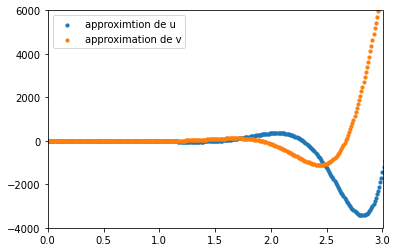

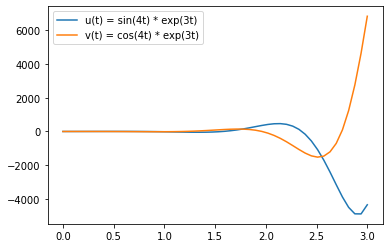

In [179]:
u0 = 0
v0 = 1

du = 3*u + 4*v
dv = -4*u + 3*v

res = Solver_two_equations(u0, v0, du, dv)

time = []
coords_u = []
coords_v = []

for i in range(0, len(res[0])):
    time.append(res[0][i][0])
    coords_u.append(res[0][i][1])
    coords_v.append(res[1][i][1])

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(time, coords_u, s=10, label='approximtion de u')
ax1.scatter(time, coords_v, s=10, label='approximation de v')
plt.xlim([0, 3])
plt.ylim([-4000, 6000])
plt.legend(loc='upper left');
plt.show()

graph = plt.subplot()
x = np.linspace(0, 3)
y = np.sin(4*x) * np.exp(3*x)
z = np.cos(4*x) * np.exp(3*x)
graph.plot(x, y, label ='u(t) = sin(4t) * exp(3t)')
graph.plot(x, z, label ='v(t) = cos(4t) * exp(3t)')
plt.legend()  
plt.show()


## Second Test
### $\frac{du}{dt} = v$
### $\frac{dv}{dt} = -u$
$u(t) = \cos(t) + \sin(t)$  ;  $v(t) = \cos(t) - \sin(t)$

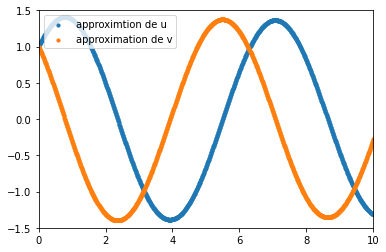

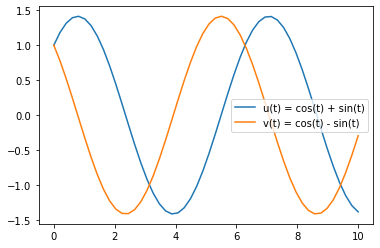

In [154]:
u0 = 1
v0 = 1

du = v
dv = -u

res = Solver_two_equations(u0, v0, du, dv)

time = []
coords_u = []
coords_v = []

for i in range(0, len(res[0])):
    time.append(res[0][i][0])
    coords_u.append(res[0][i][1])
    coords_v.append(res[1][i][1])

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(time, coords_u, s=10, label='approximtion de u')
ax1.scatter(time, coords_v, s=10, label='approximation de v')
plt.xlim([0, 10])
plt.ylim([-1.5, 1.5])
plt.legend(loc='upper left');
plt.show()

graph = plt.subplot()
x = np.linspace(0, 10)
y = np.cos(x) + np.sin(x)
z = np.cos(x) - np.sin(x)
graph.plot(x, y, label ='u(t) = cos(t) + sin(t)')
graph.plot(x, z, label ='v(t) = cos(t) - sin(t)')
plt.legend()  
plt.show()
